In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### A4.17: Heuristic Suboptimal Solution for Boolean LP ###

In [3]:
np.random.seed(0)
m, n = 300, 100
A = np.random.rand(m, n)
b = A.dot(np.ones(n)) / 2
c =-np.random.rand(n)

In [4]:
x = cp.Variable(n)
constr = [A @ x <= b, x >= 0, x <= 1]
obj = cp.Minimize(c.T @ x)
prob = cp.Problem(obj, constr)
prob.solve()
print("optimal value", prob.value)
# print("optimal var", x.value)

optimal value -34.41722426062946


In [5]:
obj_vals = []
max_contsr_violation = []
ts = []

for t in range(1, 100):
    thresh = t / 100.0
    ts.append(thresh)
    x_thres = np.where(x.value >= thresh, 1, 0)
    obj_val = c.T @ x_thres
    obj_vals.append(obj_val)
    constr_violation = np.max(A @ x_thres - b)
    max_contsr_violation.append(constr_violation)

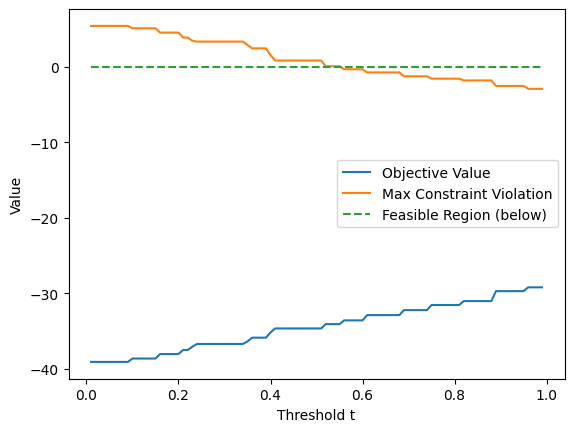

In [6]:
plt.plot(ts, obj_vals, label="Objective Value")
plt.plot(ts, max_contsr_violation, label="Max Constraint Violation")
plt.plot(ts, np.zeros_like(ts), label="Feasible Region (below)", linestyle='--')
plt.xlabel("Threshold t")
plt.ylabel("Value")
plt.legend()
plt.show()

In [7]:
valid_idx = [i for i, v in enumerate(max_contsr_violation) if v <= 0]
idx = valid_idx[np.argmin([obj_vals[i] for i in valid_idx])]
x_final = np.where(x.value >= ts[idx], 1, 0)
print("Upper bound objective value:", c.T @ x_final)
print("Lower bound objective value:", prob.value)
print("Gap:", (c.T @ x_final) - prob.value)

Upper bound objective value: -33.57725134530702
Lower bound objective value: -34.41722426062946
Gap: 0.8399729153224413


### 5.1 Numerical Perturbation Analysis Example ###

In [57]:
x1 = cp.Variable()
x2 = cp.Variable()
u1 = cp.Parameter()
u2 = cp.Parameter()
obj51 = cp.Minimize(0.5*x1**2 + 1.5*x2**2 + 0.5*((x1-x2)**2) -x1)
constr51 = [x1 + 2*x2 <= u1, x1 - 4*x2 <= u2, 5*x1 + 76*x2 <= 1]
prob51 = cp.Problem(obj51, constr51)

u1.value = -2
u2.value = -3

In [58]:
prob51.solve()
print("p*", prob51.value)
print("x1*", x1.value)
print("x2*", x2.value)
print("lambda1*", constr51[0].dual_value)
print("lambda2*", constr51[1].dual_value)
print("lambda3*", constr51[2].dual_value)

p* 8.222222222222227
x1* -2.333333333333334
x2* 0.16666666666666674
lambda1* 2.5491946097110323
lambda2* 3.0217342613792235
lambda3* 0.05248089244861612


**5.1 a)** 
KKT Condition Verification
1. All constraints satisfy $f_i(x*) <= 0$
2. All lambdas are positive (satisfied above)
3. $ \lambda_i * f_i(x*) = 0 $
4. Gradient of Langrangian: 
$
\begin{bmatrix}
2x_1 - x_2 - 1 \\
4x_2 - x_1
\end{bmatrix} +
\lambda_1 
\begin{bmatrix}
1 \\
2
\end{bmatrix} +
\lambda_2
\begin{bmatrix}
1 \\
-4
\end{bmatrix}+
\lambda_3
\begin{bmatrix}
5 \\
76
\end{bmatrix}
$

In [59]:
print("f1(x*): " + str(x1.value + 2*x2.value - u1.value))
print("f2(x*): " + str(x1.value - 4*x2.value - u2.value))
print("f3(x*): " + str(5*x1.value + 76*x2.value - 1))
print("Thus primal constraints are satisfied.")
print("============================================")
print("lambda1*f1(x*): " + str(constr51[0].dual_value * (x1.value + 2*x2.value - u1.value)))
print("lambda2*f2(x*): " + str(constr51[1].dual_value * (x1.value - 4*x2.value - u2.value)))
print("lambda3*f3(x*): " + str(constr51[2].dual_value * (5*x1.value + 76*x2.value - 1)))
print("Thus complementary slackness holds.")
print("============================================")
print("grad f(x*): " + str(np.array([2*x1.value - x2.value - 1 + constr51[0].dual_value + constr51[1].dual_value + 5*constr51[2].dual_value,
                                     4*x2.value - x1.value + 2*constr51[0].dual_value - 4*constr51[1].dual_value + 76*constr51[2].dual_value])))
print("Thus gradient of the langrangian is zero.")

f1(x*): -4.440892098500626e-16
f2(x*): -8.881784197001252e-16
f3(x*): 1.7763568394002505e-15
Thus primal constraints are satisfied.
lambda1*f1(x*): -1.132069819980611e-15
lambda2*f2(x*): -2.683839161025524e-15
lambda3*f3(x*): 9.32247922389282e-17
Thus complementary slackness holds.
grad f(x*): [ 1.55431223e-15 -3.55271368e-15]
Thus gradient of the langrangian is zero.


In [64]:
p_star = prob51.value
d1s = [-0.1, 0.0, 0.1]
d2s = [-0.1, 0.0, 0.1]
for d1 in d1s:
    for d2 in d2s:
        p_pred = p_star - constr51[0].dual_value * d1 - constr51[1].dual_value * d2
        u1.value = -2 + d1
        u2.value = -3 + d2
        prob51.solve()
        p_exact = prob51.value
        print(f"d1: {d1},\t d2: {d2},\t p_pred: {p_pred:.4f},\t p_exact: {p_exact:.4f}")
        u1.value = -2
        u2.value = -3
print("p_pred* <= p_exact* holds for all deltas!")

d1: -0.1,	 d2: -0.1,	 p_pred: 8.2155,	 p_exact: 8.8156
d1: -0.1,	 d2: 0.0,	 p_pred: 8.1021,	 p_exact: 8.5650
d1: -0.1,	 d2: 0.1,	 p_pred: 7.8499,	 p_exact: 8.3189
d1: 0.0,	 d2: -0.1,	 p_pred: 7.9954,	 p_exact: 8.7064
d1: 0.0,	 d2: 0.0,	 p_pred: 7.7515,	 p_exact: 8.2222
d1: 0.0,	 d2: 0.1,	 p_pred: 7.3011,	 p_exact: 7.9800
d1: 0.1,	 d2: -0.1,	 p_pred: 7.6565,	 p_exact: 8.7064
d1: 0.1,	 d2: 0.0,	 p_pred: 7.7515,	 p_exact: 8.2222
d1: 0.1,	 d2: 0.1,	 p_pred: 7.2741,	 p_exact: 7.7515
p_pred* <= p_exact* holds for all deltas!


### A17.5) Simple Portfolio Optimization ###

In [98]:
np.random.seed(1)
n = 20
pbar = np.ones((n, 1)) * 0.03 
pbar += np.r_[np.random.rand(n - 1, 1), np.zeros((1, 1))] * 0.12
S = np.random.randn(n, n)
S = S.T @ S
S = S / max(np.abs(np.diag(S))) * 0.2
S[:, -1] = np.zeros(n)
S[-1, :] = np.zeros(n)
x_unif = np.ones((n, 1)) / n
print("Risk of uniform portfolio:", x_unif.T @ S @ x_unif)

Risk of uniform portfolio: [[0.004437]]


In [99]:
x = cp.Variable(n)
obj175 = x.T @ S @ x
constr175 = [pbar.T @ x >= pbar.T @ x_unif, x.sum() == 1] #, x >= 0
prob175 = cp.Problem(cp.Minimize(obj175), constr175)
prob175.solve()
print("Risk with no other constraints:", prob175.value)
return0 = pbar.T @ x.value

Risk with no other constraints: 8.158032469098843e-05


In [100]:
constr175a = [pbar.T @ x >= pbar.T @ x_unif, x.sum() == 1, x >= 0]
prob175a = cp.Problem(cp.Minimize(obj175), constr175a)
prob175a.solve()
print("Risk with long-only constraint:", prob175a.value)

Risk with long-only constraint: 0.0015602874473355844


In [101]:
constr175b = [pbar.T @ x >= pbar.T @ x_unif, x.sum() == 1, cp.sum(cp.maximum(-x, 0)) <= 0.5]
prob175b = cp.Problem(cp.Minimize(obj175), constr175b)
prob175b.solve()
print("Risk with limit on total short positions:", prob175b.value)

Risk with limit on total short positions: 0.00022420561202894906


The risk is lowest with no additional constraints, followed by the limit on total short positions, and then long-only constraint, and finally the uniform portfolio.

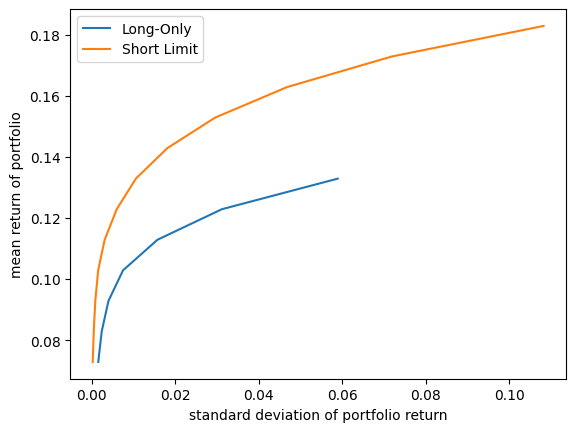

In [107]:
long_only_returns = []
long_only_risks = []

short_limit_returns = []
short_limit_risks = []
for i in range(0, 20):
    fixed_return = return0 + i * 0.01
    constr_long_only = [pbar.T @ x >= fixed_return, x.sum() == 1, x >= 0]
    prob_long_only = cp.Problem(cp.Minimize(obj175), constr_long_only)
    prob_long_only.solve()
    long_only_returns.append(fixed_return)
    long_only_risks.append(prob_long_only.value)

    constr_short_limit = [pbar.T @ x >= fixed_return, x.sum() == 1, cp.sum(cp.maximum(-x, 0)) <= 0.5]
    prob_short_limit = cp.Problem(cp.Minimize(obj175), constr_short_limit)
    prob_short_limit.solve()
    short_limit_returns.append(fixed_return)
    short_limit_risks.append(prob_short_limit.value)

plt.plot(long_only_risks, long_only_returns, label="Long-Only")
plt.plot(short_limit_risks, short_limit_returns, label="Short Limit")
plt.xlabel("standard deviation of portfolio return")
plt.ylabel("mean return of portfolio")
plt.legend()
plt.show()


### A20.10) Energy Storage Tradeoffs ###

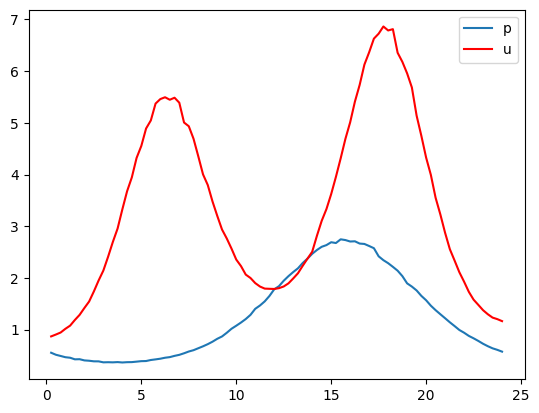

In [65]:
np.random.seed(1)

T = 96
t = np.linspace(1, T, num=T).reshape(T,1)
p = np.exp(-np.cos((t-15)*2*np.pi/T)+0.01*np.random.randn(T,1))
u = 2*np.exp(-0.6*np.cos((t+40)*np.pi/T) \
             - 0.7*np.cos(t*4*np.pi/T)+0.01*np.random.randn(T,1))

plt.figure(1)
plt.plot(t/4, p)
plt.plot(t/4, u, 'r')
plt.legend(['p', 'u'])
plt.show()

a) Minimize cost $$p^T (u + c)$$ subject to 
$$ q_t \leq Q \\ 
c_t \leq C \\
c_t \geq -D \\
q_{t+1} = q_t + c_t
q_1 = q_T + c_T \\
u_t + c_t \geq 0
$$

In [125]:
Q = cp.Parameter()
C = cp.Parameter()
D = cp.Parameter()

Q.value = 35
C.value = 3
D.value = 3

c = cp.Variable((T, 1))
q = cp.Variable((T, 1))
obj2010 = p.T @ (u+c)
constr2010 = [
    q >= 0,
    q <= Q,
    c <= C,
    c >= -D,
    u + c >= 0,
    q[1:] == q[:-1] + c[:-1],
    q[0] == q[-1] + c[-1]
]
prob2010 = cp.Problem(cp.Minimize(obj2010), constr2010)
print("Optimal value to problem posed in part a)", prob2010.solve())

Optimal value to problem posed in part a) 379.4109771623206


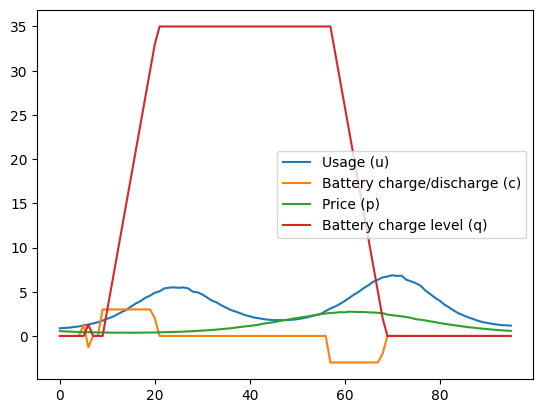

In [126]:
plt.plot(u, label="Usage (u)")
plt.plot(c.value, label="Battery charge/discharge (c)")
plt.plot(p, label="Price (p)")
plt.plot(q.value, label="Battery charge level (q)")
plt.legend()
plt.show()

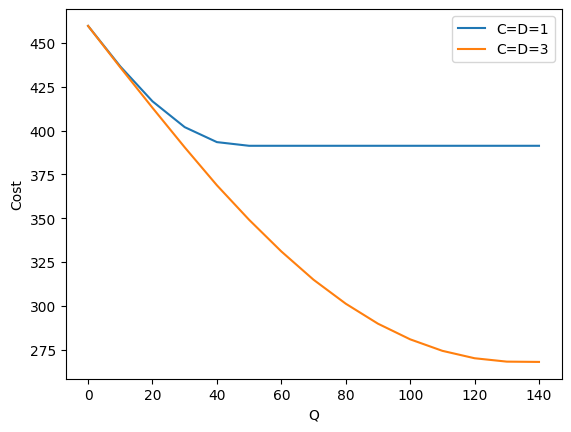

In [133]:
costs_cd1 = []
costs_cd3 = []
for q in range (0, 150, 10):
    Q.value = q
    C.value = 3
    D.value = 3
    costs_cd3.append(prob2010.solve())

    C.value = 1
    D.value = 1
    costs_cd1.append(prob2010.solve())

plt.plot(range(0, 150, 10), costs_cd1, label="C=D=1")
plt.plot(range(0, 150, 10), costs_cd3, label="C=D=3")
plt.xlabel("Q")
plt.ylabel("Cost")
plt.legend()

At the endpoint Q = 0, we don't have a battery. With the larger C and D parameters, we're able to adapt more aggressively to the flucuating prices, so it takes larger battery capacity Q before we hit a plateau of cost improvement with the battery.